## BatchNorm, LayerNorm, and RMSNorm

In [ ]:
import numpy as np

dilatation_factor = np.array([0.5, 5., 1.])
translation = np.array([1, 2, 0])
X = np.random.randn(100, 3)* dilatation_factor  + translation  # 10 samples, 3 dimensions
X[:5]

array([[  0.15608688,   6.87924272,   1.30912975],
       [  1.99824755,   2.08578815,   0.52187515],
       [  1.09018602,  -4.42875283,  -1.18322029],
       [  1.10910789, -10.34380653,   1.21365519],
       [  0.83099311,  -1.9391465 ,   0.17790401]])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.set_loglevel("ERROR")

## Exercise: apply BatchNorm, LayerNorm, and RMSNorm to X

In [ ]:
epsilon = 1e-9

X_bn = ...

In [ ]:
X[:5]

array([[  0.15608688,   6.87924272,   1.30912975],
       [  1.99824755,   2.08578815,   0.52187515],
       [  1.09018602,  -4.42875283,  -1.18322029],
       [  1.10910789, -10.34380653,   1.21365519],
       [  0.83099311,  -1.9391465 ,   0.17790401]])

In [ ]:
# @title Solution
epsilon = 1e-9

# Batch Norm
mean = np.mean(X, axis=0)
var = np.var(X, axis=0)

X_bn = (X - mean) / np.sqrt(var + epsilon)

# LayerNorm
mean = np.mean(X, axis=1)
mean = np.expand_dims(mean, axis=1)
var = np.var(X, axis=1)
var = np.expand_dims(var, axis=1)

X_ln = (X - mean) / np.sqrt(var + epsilon)

# RMSNorm
X_rms = X / np.sqrt(var + epsilon)

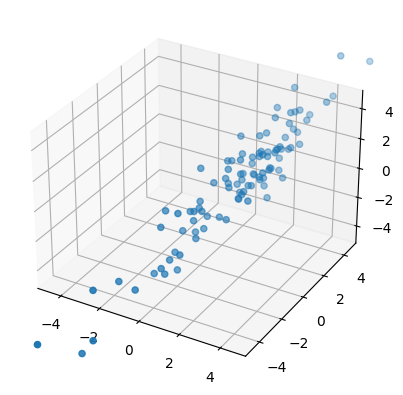

In [ ]:
def plot_vectors(X, colors=None):
  x = X[:, 0]
  y = X[:, 1]
  z = X[:, 2]
  # Create a 3D scatter plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the points
  ax.scatter(x, y, z, c=colors)
  ax.set_xlim(-5, 5)
  ax.set_ylim(-5, 5)
  ax.set_zlim(-5, 5)

plot_vectors(X)

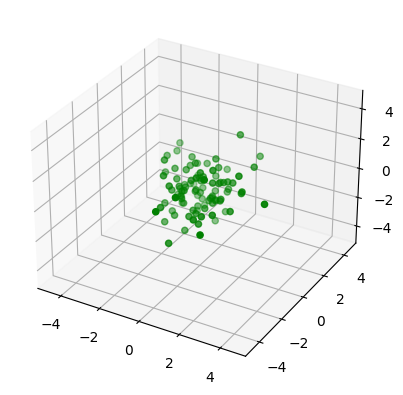

In [ ]:
plot_vectors(X_bn, colors="green")

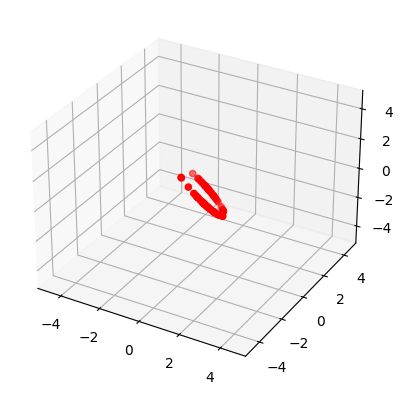

In [ ]:
plot_vectors(X_ln, colors="red")

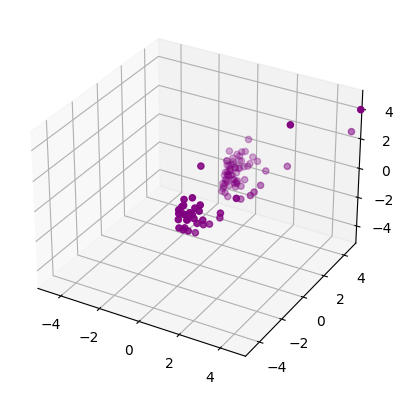

In [ ]:
plot_vectors(X_rms, colors="purple")

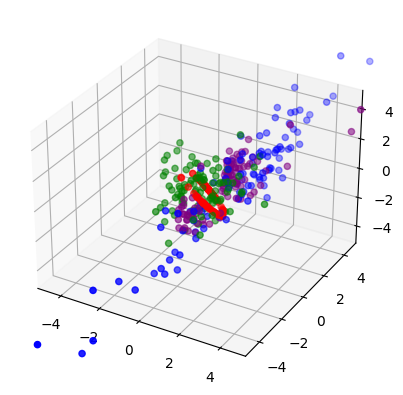

In [ ]:
plot_vectors(
    np.concatenate((X, X_bn, X_ln, X_rms)),
    colors=["blue"]*len(X)+["green"]*len(X_bn)+["red"]*len(X_ln)+["purple"]*len(X_rms)
  )

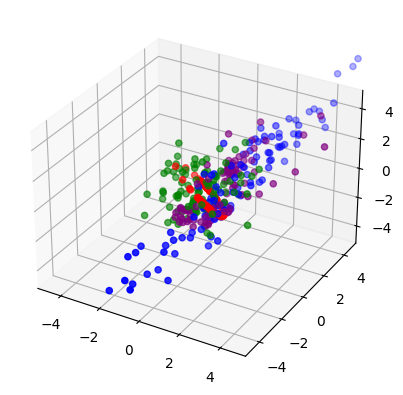

In [ ]:
plot_vectors(
    np.concatenate((X, X_bn, X_ln, X_rms)),
    colors=["blue"]*len(X)+["green"]*len(X_bn)+["red"]*len(X_ln)+["purple"]*len(X_rms)
  )

## Exercise: implement an RMSNorm layer

RMSNorm is defined by
$$
\text{RMSNorm}(x) = \frac{x}{\text{RMS}(x)} \cdot \gamma
$$
where RMS is the Root-Mean Squared (standard deviation but without the mean term) and $\gamma$ is a learned vector.

Think about test cases to confirm that your implementation behaves as expected.

In [ ]:
# @title Solution
import torch
from torch import nn
from einops import reduce

class RMSNorm(nn.Module):
    def __init__(self, emb_dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(emb_dim))

    def forward(self, x):
        # Note: explicit casting to fp32 to avoid numerical underflow
        x_fp32 = x.to(torch.float32)
        mean_square = reduce(x_fp32**2, '... d -> ... 1', 'mean')
        inverse_rms = torch.rsqrt(mean_square + self.eps)
        inverse_rms = inverse_rms.type_as(x)  # For fp16 compatibility
        return self.weight * x * inverse_rms

norm_layer = RMSNorm(dim=3)
norm_layer(torch.tensor(X))

tensor([ 0.6878,  0.9060, -0.5541, -0.4422, -0.2537,  0.4236,  0.4777,  0.5605,
         0.7675,  0.7777,  0.9924,  0.8401,  0.6906,  0.6138,  0.6222,  0.5913,
         0.0774, -0.5130, -0.2963,  0.4644,  0.7176, -0.5241, -0.0976,  0.9862,
         0.6625,  0.7454,  0.5890, -0.3831, -0.4470,  0.6108,  0.3609, -0.1107,
         0.6167,  0.6490, -0.6669, -0.6546,  0.7920,  0.2926,  0.5783,  0.8326,
        -0.3581,  0.6832,  0.2911,  0.6527, -0.5222,  0.9547,  0.5854, -0.4145,
         0.4909,  0.5242,  0.6931,  0.2535, -0.6884,  0.7097,  0.8428,  0.7029,
         0.7691,  0.8764,  0.9720, -0.4770, -0.6594,  0.9797,  0.7249,  0.5664,
         0.4792, -0.6299,  0.9893, -0.2378,  0.6407,  0.3202,  0.7878,  0.3823,
         0.6716,  0.5923,  0.7280, -0.0890,  0.8184,  0.5624,  0.5669,  0.5013,
         0.5927,  0.5356,  0.5200,  0.7051, -0.6999, -0.5647, -0.4065, -0.5422,
         0.6520, -0.4438, -0.3945,  0.8063,  0.7860,  0.8446, -0.4875,  0.5651,
         0.7782,  0.7629,  0.5801,  0.69